In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer

from scipy.stats import randint

import os

import mlflow

In [2]:
mlflow.set_experiment("Introverts and Extroverts")

<Experiment: artifact_location='file:///home/mshopov/Jupyter%20Lab%20Notebooks/Kaggle%20Competitions/Predict%20the%20Introverts%20from%20the%20Extroverts/mlruns/683743730939363783', creation_time=1751656660627, experiment_id='683743730939363783', last_update_time=1751656660627, lifecycle_stage='active', name='Introverts and Extroverts', tags={}>

In [3]:
data = pd.read_csv("data/train.csv", index_col = "id")

In [4]:
data.columns = data.columns.str.lower()

In [5]:
# Separate categorical and numerical columns
cat_cols = data.select_dtypes(include=["object", "category"]).columns
num_cols = data.select_dtypes(include=["number"]).columns

data_encoded = data.copy()

# Encode categorical columns
encoder = OrdinalEncoder()
data_encoded[cat_cols] = encoder.fit_transform(data[cat_cols])

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data.columns, index=data.index)

# Decode the categorical columns back to original labels
data_imputed[cat_cols] = encoder.inverse_transform(data_imputed[cat_cols])

In [6]:
X = data_imputed.drop(columns = ["personality"])
y = data_imputed.personality

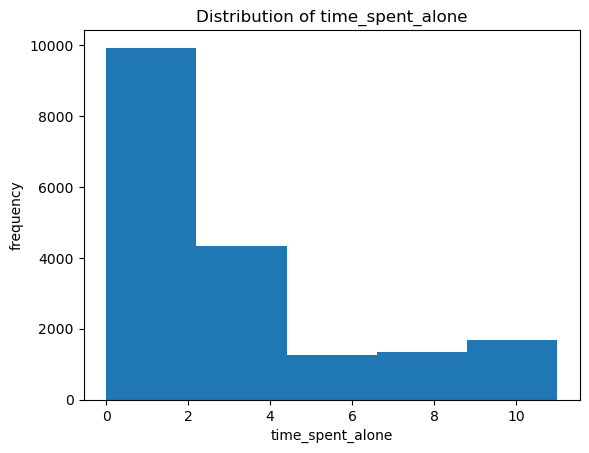

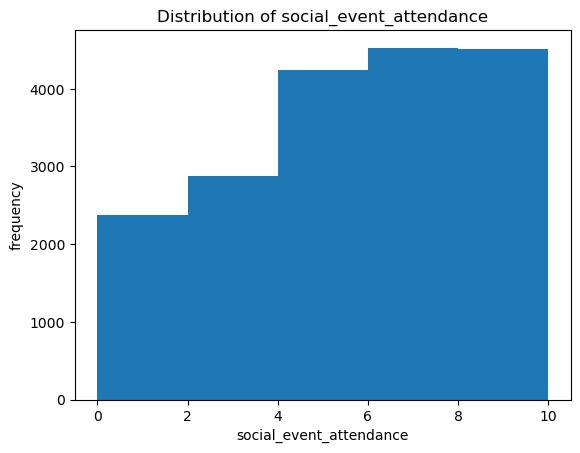

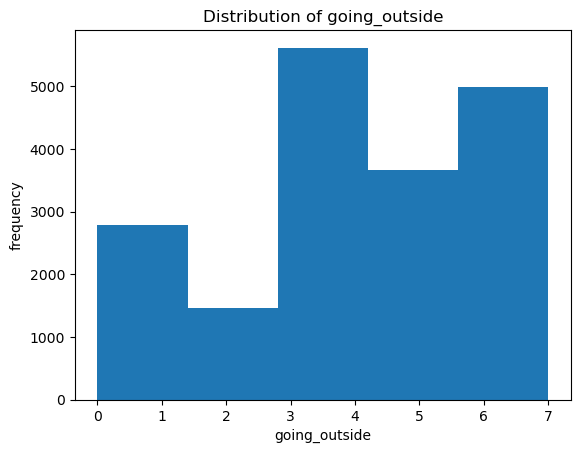

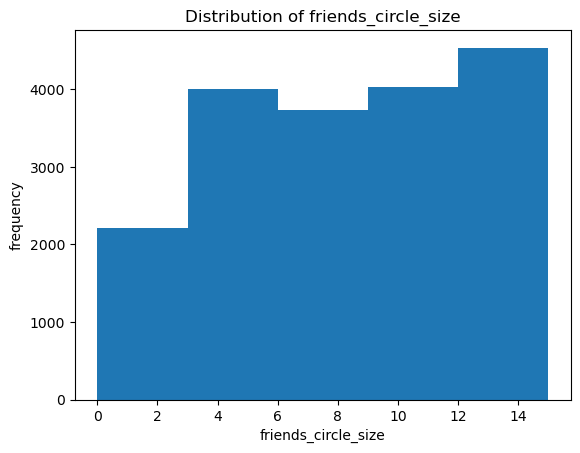

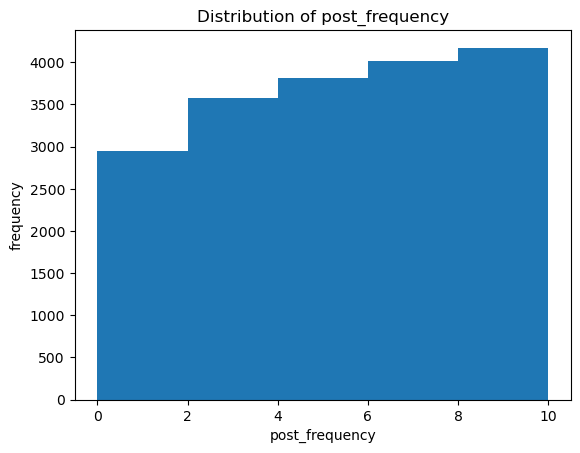

In [8]:
categorical_features = list(X.dtypes[X.dtypes == "object"].index)
numerical_features = list(X.dtypes[X.dtypes == "float64"].index)

for column in numerical_features:
    plt.hist(X[column], bins = 5)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("frequency")
    plt.show()

In [9]:
len(X)

18524

In [10]:
train_test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=train_test_ratio, stratify=y, random_state=17
)

---

### Single Models

In [11]:
preprocessor = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(drop = "first"), categorical_features),
    ],
    remainder = "passthrough"
)

poly_feat = PolynomialFeatures(degree = 2)
scaler = MinMaxScaler()
rand_forest = RandomForestClassifier(n_estimators=100)

classifier_pipeline = Pipeline(
    steps = [
        ("preprocessing", preprocessor),
        ("poly_features", poly_feat),
        ("scaler", scaler),
        ("classifier", rand_forest)
    ]
)

In [12]:
with mlflow.start_run():

    # Fit the pipeline
    classifier_pipeline.fit(X_train, y_train)

    # Predict and calculate accuracy
    train_acc = accuracy_score(y_train, classifier_pipeline.predict(X_train))
    test_acc = accuracy_score(y_test, classifier_pipeline.predict(X_test))

    # Log parameters
    mlflow.log_param("train_test_split", f"train: {1 - train_test_ratio}, test: {train_test_ratio}")
    mlflow.log_param("poly_degree", poly_feat.degree)
    mlflow.log_param("scaler", type(scaler).__name__)
    mlflow.log_param("classifier", type(rand_forest).__name__)
    mlflow.log_params(rand_forest.get_params())
    mlflow.log_param("categorical_features", categorical_features)
    mlflow.log_param("preprocessing", "OneHotEncoder(drop='first') + passthrough")

    # Log metrics
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Log the entire pipeline
    mlflow.sklearn.log_model(classifier_pipeline, "classifier")

    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

2025/07/05 09:31:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train accuracy: 0.9949
Test accuracy: 0.9603


---

### Randomized Search CV

In [37]:
preprocessor = ColumnTransformer(
    [("ohe", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

# Pipeline steps
pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("poly_features", PolynomialFeatures()),
        ("scaler", MinMaxScaler()),
        ("classifier", RandomForestClassifier(random_state=17))
    ]
)

# Hyperparameter distributions for randomized search
param_distributions = {
    "poly_features__degree": [2, 3, 4],
    "classifier__n_estimators": randint(100, 500),
    "classifier__max_depth": [None, 5, 10, 20, 30],
    "classifier__max_features": ["sqrt", "log2", None],
    "classifier__min_samples_split": randint(2, 10)
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    random_state=17,
    n_jobs=-1
)

In [38]:
# MLflow logging
with mlflow.start_run():
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Log best parameters
    mlflow.log_params(random_search.best_params_)
    mlflow.log_param("categorical_features", categorical_features)
    mlflow.log_param("scaler", "MinMaxScaler")
    mlflow.log_param("preprocessing", "OneHotEncoder(drop='first') + passthrough")

    # Log metrics
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Log model
    mlflow.sklearn.log_model(best_model, "classifier")

    print("Best parameters:", random_search.best_params_)
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

2025/07/04 22:36:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_split': 9, 'classifier__n_estimators': 241, 'poly_features__degree': 4}
Train accuracy: 0.9729
Test accuracy: 0.9673


---
### Submissions: Single Models

In [30]:
accuracy_score(y_train, classifier_pipeline.predict(X_train))

0.994938929752345

In [31]:
accuracy_score(y_test, classifier_pipeline.predict(X_test))

0.9603238866396762

In [32]:
eval_data = pd.read_csv("data/test.csv", index_col="id")

In [33]:
eval_data.columns = eval_data.columns.str.lower()

In [34]:
# Separate categorical and numerical columns
cat_cols = eval_data.select_dtypes(include=["object", "category"]).columns
num_cols = eval_data.select_dtypes(include=["number"]).columns

eval_data_encoded = eval_data.copy()

# Encode categorical columns
encoder = OrdinalEncoder()
eval_data_encoded[cat_cols] = encoder.fit_transform(eval_data[cat_cols])

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
eval_data_imputed = pd.DataFrame(imputer.fit_transform(eval_data_encoded), columns=eval_data.columns, index=eval_data.index)

# Decode the categorical columns back to original labels
eval_data_imputed[cat_cols] = encoder.inverse_transform(eval_data_imputed[cat_cols])


In [35]:
submission = pd.DataFrame({
    "id": eval_data_imputed.index,
    "Personality": classifier_pipeline.predict(eval_data_imputed)
})
submission

id Personality
0     18524   Extrovert
1     18525   Introvert
2     18526   Extrovert
3     18527   Extrovert
4     18528   Introvert
...     ...         ...
6170  24694   Extrovert
6171  24695   Introvert
6172  24696   Extrovert
6173  24697   Extrovert
6174  24698   Introvert

[6175 rows x 2 columns]

In [36]:
# Find the lowest available index X
existing_files = os.listdir("submissions")
used_indices = set()

for filename in existing_files:
    if filename.startswith("submission_") and filename.endswith(".csv"):
        try:
            index = int(filename[len("submission_"):].split("_")[0])
            used_indices.add(index)
        except ValueError:
            pass  # skip files with non-integer suffixes

# Find the lowest unused index
X = 0
while X in used_indices:
    X += 1

# Set index of the DataFrame to X (repeating the same value)
submission.index = [X] * len(submission)

# Build the filename
accuracy_str = str(accuracy_score(y_test, classifier_pipeline.predict(X_test))).replace(".", "_")
file_path = f"submissions/submission_{X}___{accuracy_str}.csv"

# Save
submission.to_csv(file_path, index = False)

print(f"Saved to {file_path}")

Saved to submissions/submission_1___0_9603238866396762.csv


---
### Submissions: Randomized Search CV

In [ ]:
accuracy_score(y_train, best_model.predict(X_train))

In [39]:
accuracy_score(y_test, best_model.predict(X_test))

0.9673414304993252

In [16]:
eval_data = pd.read_csv("data/test.csv", index_col="id")

In [17]:
eval_data.columns = eval_data.columns.str.lower()

In [18]:
# Separate categorical and numerical columns
cat_cols = eval_data.select_dtypes(include=["object", "category"]).columns
num_cols = eval_data.select_dtypes(include=["number"]).columns

# Make a copy to avoid modifying the original
eval_data_encoded = eval_data.copy()

# Encode categorical columns
encoder = OrdinalEncoder()
eval_data_encoded[cat_cols] = encoder.fit_transform(eval_data[cat_cols])

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
eval_data_imputed = pd.DataFrame(imputer.fit_transform(eval_data_encoded), columns=eval_data.columns, index=eval_data.index)

# Decode the categorical columns back to original labels
eval_data_imputed[cat_cols] = encoder.inverse_transform(eval_data_imputed[cat_cols])


In [47]:
submission = pd.DataFrame({
    "id": eval_data_imputed.index,
    "Personality": best_model.predict(eval_data_imputed)
})
submission

id Personality
0     18524   Extrovert
1     18525   Introvert
2     18526   Extrovert
3     18527   Extrovert
4     18528   Introvert
...     ...         ...
6170  24694   Extrovert
6171  24695   Introvert
6172  24696   Extrovert
6173  24697   Extrovert
6174  24698   Introvert

[6175 rows x 2 columns]

In [ ]:
# Find the lowest available index X
existing_files = os.listdir("submissions")
used_indices = set()

for filename in existing_files:
    if filename.startswith("submission_") and filename.endswith(".csv"):
        try:
            index = int(filename[len("submission_"):].split("_")[0])
            used_indices.add(index)
        except ValueError:
            pass  # skip files with non-integer suffixes

# Find the lowest unused index
X = 0
while X in used_indices:
    X += 1

# Set index of the DataFrame to X (repeating the same value)
submission.index = [X] * len(submission)

# Build the filename
accuracy_str = str(accuracy_score(y_test, best_model.predict(X_test))).replace(".", "_")
file_path = f"submissions/submission_{X}___{accuracy_str}.csv"

# Save
submission.to_csv(file_path, index = False)

print(f"Saved to {file_path}")

---
### Manual Submissions

In [11]:
accuracy_score(
    pd.read_csv("submissions/submission_1___0_9603238866396762.csv")["Personality"],
    pd.read_csv("submissions/submission_0___0_9673414304993252.csv")["Personality"]
)

0.9928744939271255

In [22]:
submission_0 = pd.read_csv("submissions/submission_0___0_9673414304993252.csv", index_col = "id")

In [30]:
drained_and_personality = pd.merge(
    eval_data_imputed.drained_after_socializing,
    submission_0.Personality,
    on = "id"
)

In [32]:
drained_and_personality.groupby("drained_after_socializing")["Personality"].value_counts()

drained_after_socializing  Personality
No                         Extrovert      4619
                           Introvert        12
Yes                        Introvert      1540
                           Extrovert         4
Name: count, dtype: int64

In [35]:
submission_2_manual = eval_data_imputed.drained_after_socializing.apply(lambda x: "Extrovert" if x == "No" else "Introvert")

In [38]:
submission_2_manual = pd.DataFrame({
    "id": submission_2_manual.index,
    "Personality": submission_2_manual.values
})

In [41]:
accuracy_score(submission_2_manual.Personality, submission_0.Personality)

0.9974089068825911

In [43]:
submission_2_manual.to_csv("submissions/submission_2__manual.csv", index = False)

---

In [52]:
eval_data_predicted = pd.merge(eval_data_imputed, submission_0.Personality, on="id")

/home/mshopov/anaconda3/envs/deep-learning-env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


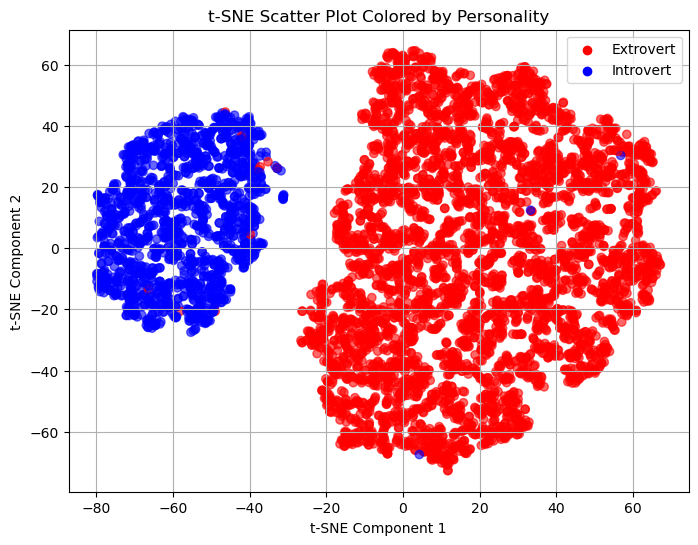

In [61]:
# 1. Copy the data
df = eval_data_predicted.copy()

# 2. Drop the target column from the features
X = df.drop(columns=["Personality", "CorrectedPersonality"])

# 3. Encode all object columns (binary object features) to numerical
for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# 4. Apply t-SNE
tsne = TSNE(n_components=2, random_state=17, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# 5. Create a color map for Personality
colors = df["Personality"].map({"Extrovert": "red", "Introvert": "blue"})

# 6. Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.6, label=None)
plt.title("t-SNE Scatter Plot Colored by Personality")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# Add legend manually
for label, color in {"Extrovert": "red", "Introvert": "blue"}.items():
    plt.scatter([], [], c=color, label=label)
plt.legend()
plt.grid(True)
plt.show()


In [74]:
eval_data_tsne = pd.DataFrame(X_tsne, index = eval_data_imputed.index)

In [75]:
eval_data_tsne.columns = ["feature_0", "feature_1"]

In [76]:
eval_data_tsne["Personality"] = ["Extrovert"] * len(eval_data_tsne) 

In [82]:
eval_data_tsne.loc[eval_data_tsne.feature_0 < -30, "Personality"] = "Introvert"

In [84]:
eval_data_tsne.loc[(eval_data_tsne.feature_0 < -20) & (eval_data_tsne.feature_1 > 0), "Personality"] = "Introvert"

In [85]:
eval_data_tsne

feature_0  feature_1 Personality
id                                     
18524 -17.404118 -38.811539   Extrovert
18525 -42.516029  13.973495   Introvert
18526  18.536951  52.107174   Extrovert
18527   3.149016 -61.456501   Extrovert
18528 -67.917061  19.254080   Introvert
...          ...        ...         ...
24694  31.503975 -15.529457   Extrovert
24695 -71.710709  18.962032   Introvert
24696  -4.721600   0.679423   Extrovert
24697   2.586965  34.854187   Extrovert
24698 -70.276817  15.921864   Introvert

[6175 rows x 3 columns]

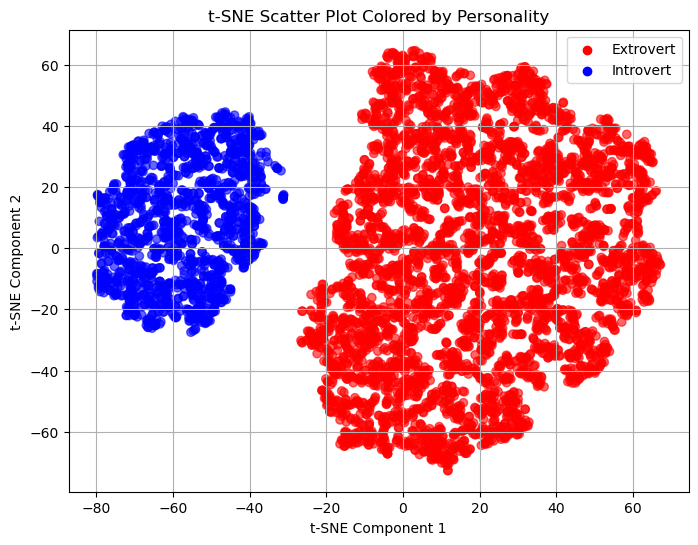

In [87]:
colors = eval_data_tsne["Personality"].map({"Extrovert": "red", "Introvert": "blue"})

plt.figure(figsize=(8, 6))
plt.scatter(eval_data_tsne.feature_0, eval_data_tsne.feature_1, c=colors, alpha=0.6, label=None)
plt.title("t-SNE Scatter Plot Colored by Personality")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# Add legend manually
for label, color in {"Extrovert": "red", "Introvert": "blue"}.items():
    plt.scatter([], [], c=color, label=label)
plt.legend()
plt.grid(True)
plt.show()

In [88]:
accuracy_score(eval_data_tsne.Personality, submission_0.Personality)

0.9978947368421053

In [91]:
submission_3_manual = pd.DataFrame({
    "Personality": eval_data_tsne.Personality
})

In [94]:
submission_3_manual

Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]

In [95]:
submission_3_manual.to_csv("submissions/submission_3__manual.csv")